https://github.com/qubvel/segmentation_models

In [0]:
!pip install git+https://github.com/qubvel/segmentation_models.git

  Cloning https://github.com/qubvel/segmentation_models.git to /tmp/pip-req-build-lp5t_n72
  Running command git clone -q https://github.com/qubvel/segmentation_models.git /tmp/pip-req-build-lp5t_n72
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 81kB 5.2MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-6klogax5/wheels/d6/18/c4/340b3ee7253119ec907ec8cf93bd2c572ee9a75eedb183b2f8
Successfully built segmentation-models


Get the data sets

In [0]:
from PIL import Image
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from skimage import img_as_float
from scipy.ndimage.morphology import binary_fill_holes as bfh

# for clustering of the results
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

Load the model

In [0]:
from keras.models import load_model
from keras.models import Model
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [0]:
# load model
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
model = load_model(r'/content/drive/My Drive/Colab Notebooks/models/segmentation/mole_seg.h5')

In [0]:
# get the layers
for l in model.layers[-5:]:
  print(l.name)

print(model.history.keys())

In [0]:
def crop_resize(img, new_size, crop=448):
    '''
    takes a PIL image
    '''
    # get the current size, pad to be square
    # make square 448x448 square
    ia = np.array(img)
    
#     print(ia.shape)
    
    side = (ia.shape[1] - crop)/2.0
    upplwr = (ia.shape[0] - crop)/2.0
    
#     print(side, upplwr)
    img = img.crop((side, upplwr, ia.shape[1] - side, ia.shape[0] - upplwr))
    return img.resize(new_size)

In [0]:
# images to test our model on
testimg_path = r'/content/drive/My Drive/Colab Notebooks/datasets/small_images'
msk_path = r'/content/drive/My Drive/Colab Notebooks/datasets/small_masks'
test_list_path = r'/content/drive/My Drive/Colab Notebooks/datasets/test_images.csv'

# read the csv and put values in a list
test_list = list(pd.read_csv(test_list_path).loc[:, 'image'].values)

# test the jaccard on the test images
num_samples = len(test_list)
sample = np.random.choice(test_list, num_samples)

In [0]:
# get the images to calculate the validation and testing scores
to_test = []
ground_truth = []
idx = 1
for fnm in sample:
    # get the images    
    test_img = Image.open(os.path.join(testimg_path, fnm))
    gt_img = Image.open(os.path.join(msk_path, os.path.splitext(fnm)[0] + '_segmentation.png'))
    
    # append them to our test list
    to_test.append(np.array(test_img))
    ground_truth.append(np.array(img_as_float(gt_img)))
    
    if idx % 100 == 0:
        print('{:.0%}'.format(float(idx)/num_samples), end='.')
        
    idx += 1

# turn test into big array
to_test = np.array(to_test)
ground_truth = np.array(ground_truth)
ground_truth[ground_truth >= 0.5] = 1.0
ground_truth[ground_truth < 0.5] = 0.0

# predict segmentation
prediction = model.predict(img_as_float(to_test))

# threshold at 0.5
prediction[prediction >= 0.5] = 1.0
prediction[prediction < 0.5] = 0.0

# # get the layer before the sigmoid function
# layer_name = 'final_conv'
# intermediate_layer_model = Model(inputs=model.input,
#                                  outputs=model.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(to_test)

19%.39%.58%.77%.96%.

We're going to build a function that calculates the eucledian distance from the centre

The result of UNet is semantic segmentation - which means that UNet indiscriminantly identifies all lesions in the given sample. We need to apply some post-processing to the results to convert this to a single blob in the middle.

https://arxiv.org/pdf/1807.08844.pdf

In [0]:
def calc_jaccard(a, b):
    # get the intersection
    intersection_ = np.zeros(a.shape)  
    inter = (a==1.0) & (b==1.0)  
    intersection_[inter] = 1
  
    # get the union
    union_ = np.zeros(a.shape)
    un = (a==1) | (b==1)
    union_[un] = 1
  
    return intersection_.sum() / float(union_.sum())

calc_jaccard(ground_truth[0, :, :], prediction[0, :, :, 0])

0.8177095098260673

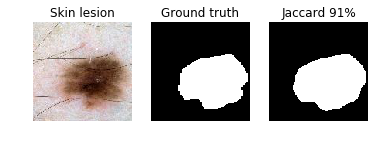

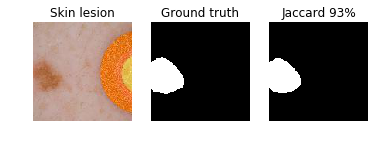

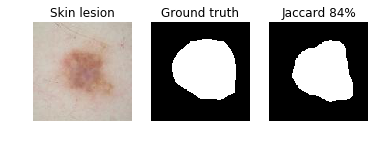

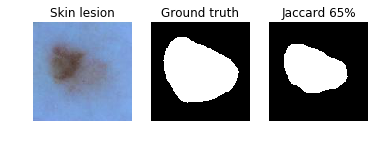

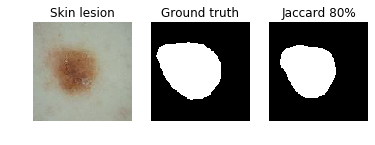

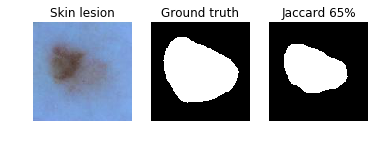

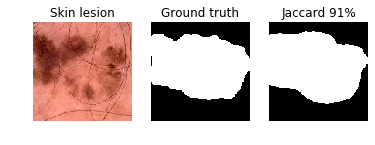

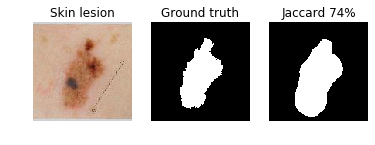

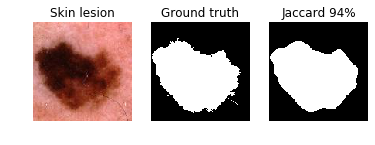

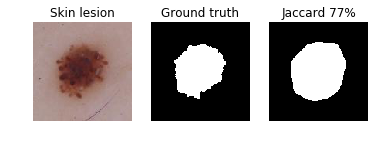

In [0]:
# for i in range(num_samples):
#   fig, axes = plt.subplots(1, 3)
#   ax = axes.flatten()
  
#   # original image
#   ax[0].imshow(to_test[i, :, :, :])
#   ax[0].set_axis_off()
#   ax[0].set_title('Skin lesion')
  
#   # ground truth mask
#   ax[1].imshow(ground_truth[i, :, :], cmap='gray')
#   ax[1].set_axis_off()
#   ax[1].set_title('Ground truth')
  
#   # our base prediction
#   ax[2].imshow(prediction[i, :, :, 0], cmap='gray')
#   ax[2].set_axis_off()
#   ax[2].set_title('Jaccard {:.0%}'.format(calc_jaccard(ground_truth[i, :, :], prediction[i, :, :, 0])))

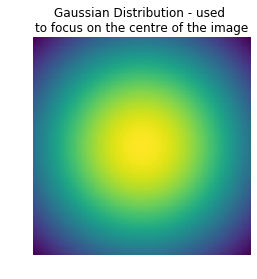

In [0]:
# create an array that has the distance from the nearest edge for a given size
def create_gaussian_array(size):
  x, y = np.meshgrid(np.linspace(-1,1,size), np.linspace(-1,1,size))
  d = np.sqrt(x*x+y*y)
  sigma, mu = 1.0, 0.0
  g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
  
  fig, ax = plt.subplots()
  ax.imshow(g, cmap='viridis')
  ax.set_axis_off()
  plt.title('Gaussian Distribution - used \nto focus on the centre of the image')
  return g
  
gaussian = create_gaussian_array(128)

In [0]:
def map2params(values, gaussian, weight=1.0, gaussian_weight=1.0):
  '''
  takes the image as an array and combine with another parameter
  apply a weighting to the value parameter to make it more important
  '''
  
  # normalise the values to between 0 and 1
  values = values - values.min()
  values = (values / float(values.max())) * weight
  gaussian = gaussian*gaussian_weight
    
  # return them together as two columns
  return np.array((values.ravel(), gaussian.ravel())).transpose()

In [0]:
# plot styles
n_clusters = 2
colors = ['#4EACC5', '#FF9C34', '#4E9A06']
masks = []
for i in range(num_samples):
  # get the intermediate array
  inter = intermediate_output[i, :, :, 0]
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  ax = axes.flatten()
  
  # plot the surface
  intl = ax[0].imshow(inter, extent=[0, 128, 0, 128], origin='upper',
           cmap='RdGy')
  ax[0].set_axis_off()
  plt.colorbar(intl, ax=ax[0])
  
  # map the gaussian distribution to the conv layer output
  X = map2params(inter, gaussian, weight=1.0, gaussian_weight=1.0)
  
  # print the result
  sns.scatterplot(X[:, 1], X[:, 0], ax=ax[1], alpha=0.7)
  ax[1].set_title('probability of central pos vs \n final convolutional layer output')
  ax[1].set_xlabel('probability of central position')
  ax[1].set_ylabel('Weighted conv value')

  # cluster the two parameters to include the positional probability
  k_means = KMeans(init='random', n_clusters=n_clusters, n_jobs=5).fit(X)
  k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
  k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
  
  # plot the clustering results
  for k, col in zip(range(n_clusters), colors):
      my_members = k_means_labels == k
      cluster_center = k_means_cluster_centers[k]
      ax[2].plot(X[my_members, 1], X[my_members, 0], 'w',
              markerfacecolor=col, marker='.')
      ax[2].plot(cluster_center[1], cluster_center[0], 'o', markerfacecolor=col,
              markeredgecolor='k', markersize=6)
      
      # plot titles and labels
      ax[2].set_title('Clustering result')
      ax[2].set_xlabel('Center prob')
      ax[2].set_ylabel('Weighted conv value')

      
  # get the max value cluster
  max_k = None
  max_val = -999
  for k in range(n_clusters):
    mean_k = X[k_means_labels == k, 1].mean()
    
    if mean_k > max_val:
      max_k = k
           
  # now use max_k to filter for all of the values and create a mask
  mask_k = np.zeros(X.shape[0])
  mask_k[k_means_labels==k] = 1
  
  # use binary fill holes to get a smoother result
  masks.append(bfh(mask_k.reshape((128,128))))  
  plt.tight_layout()

processed = np.array(masks)

NameError: ignored